# Model Selection For Machine Learning

In this exercise, we will explore methods to do model selection in a machine learning context, in particular cross-validation and information criteria. At the same time, we'll learn about `scikit-learn`'s class structure and how to build a pipeline.

## Why Model Selection?

There are several reasons why you might want to perform model selection:

* You might not be sure which machine learning algorithm is most appropriate.
* The algorithm you have chosen might have a regularization parameter whose value you want to determine.
* The algorithm you have chosen might have other parameters (e.g. the depth of a decision tree, the number of clusters in `KMeans`, ...) you would like to determine.
* You might not be sure which of your features are the most useful/predictive.

**Question**: Can you think of other reasons and contexts in which model selection might be important?

Your decisions for how to do model selection depend very strongly (like everything else in machine learning) on the purpose of your machine learning procedure. Is your main purpose to accurately **predict** outcomes for new samples? Or are you trying to **infer** something about the system? 

Inference generally restricts the number of algorithms you can reasonably use, and also the number of model selection procedures you can apply. In the following, assume that everything below works for prediction problems; I will point out methods for inference where appropriate. Additionally, assume that everything below works for *supervised machine learning*. We will cover *unsupervised* methods further below.

## Imports

Let's first import some stuff we're going to need.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# comment out this line if you don't have seaborn installed
import seaborn as sns
sns.set_palette("colorblind")

import numpy as np

First, we're going to need some data. We'll work with the star-galaxy data from the first session. This uses the `astroquery` package and then queries the top 10000 observations from SDSS (see [this exercise](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session1/Day4/StarGalaxyRandomForest.ipynb) for more details):

In [3]:
# execute this line:
from astroquery.sdss import SDSS


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [4]:
TSquery = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
             ORDER BY p.objid ASC
               """
SDSSts = SDSS.query_sql(TSquery)
SDSSts


psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
float64,float64,float64,float64,float64,float64,float64,float64,bytes6
18.50319,18.65275,19.33509,17.54539,17.31526,17.58132,17.58132,17.48715,GALAXY
19.02659,19.32441,19.80892,19.05827,19.03468,19.03111,19.03111,19.03111,STAR
19.8809,19.77895,20.46623,19.3534,19.1864,19.35493,19.35493,19.24559,GALAXY
22.03563,22.06141,22.68416,21.51795,21.03554,21.31751,21.31751,21.31751,GALAXY
21.56726,21.57312,22.22178,20.4583,19.93309,20.39825,20.39819,20.20402,GALAXY
18.66813,18.75309,19.36792,17.83372,17.69468,17.89914,17.6947,17.75269,GALAXY
20.19068,20.33947,20.93226,19.77666,19.63458,19.74873,19.74872,19.74873,GALAXY
19.41619,19.38348,20.15486,17.67687,17.16815,17.63962,17.63962,17.63962,GALAXY
18.88878,18.91179,19.57415,17.3317,17.02896,17.43539,17.02898,17.06256,GALAXY


**Exercise 1**: Visualize this data set. What representation is most appropriate, do you think?

**Exercise 2**: Let's now do some machine learning. In this exercise, you are going to use a random forest classifier to classify this data set. Here are the steps you'll need to perform:
* Split the column with the classes (stars and galaxies) from the rest of the data
* Cast the features and the classes to numpy arrays
* Split the data into a *test* set and a *training* set. The training set will be used to train the classifier; the test set we'll reserve for the very end to test the final performance of the model (more on this on Friday). You can use the `scikit-learn` function `test_train_split` for this task
* Define a `RandomForest` object from the `sklearn.ensemble` module. Note that the `RandomForest` class has three parameters:
    - `n_estimators`: The number of decision trees in the random forest
    - `max_features`: The maximum number of features to use for the decision trees
    - `min_samples_leaf`: The minimum number of samples that need to end up in a terminal leaf (this effectively limits the number of branchings each tree can make)
* We'll want to use *cross-validation* to decide between parameters. You can do this with the `scikit-learn` class `GridSearchCV`. This class takes a classifier as an input, along with a dictionary of the parameter values to search over.

In the earlier lecture, you learned about four different types of cross-validation:
* hold-out cross validation, where you take a single validation set to compare your algorithm's performance to
* k-fold cross validation, where you split your training set into k subsets, each of which holds out a different portion of the data
* leave-one-out cross validation, where you have N different subsets, each of which leaves just one sample as a validation set
* random subset cross validation, where you pick a random subset of your data points k times as your validation set.

**Exercise 2a**: Which of the four algorithms is most appropriate here? And why?

**Answer**: In this case, k-fold CV or random subset CV seem to be the most appropriate algorithms to use.
* Using hold-out cross validation leads to a percentage of the data not being used for training at all. 
* Given that the data set is not too huge, using k-fold CV probably won't slow down the ML procedure too much.
* LOO CV is particularly useful for small data sets, where even training on a subset of the training data is difficult (for example because there are only very few examples of a certain class). 
* Random subset CV could also yield good results, since there's no real ordering to the training data. Do not use this algorithm when the ordering matters (for example in Hidden Markov Models)

**Important:** One important thing to remember that cross-validation crucially depends on your *samples* being **independent** from each other. Be sure that this is the case before using it. For example, say you want to classify images of galaxies, but your data set is small, and you're not sure whether your algorithm is rotation independent. So you might choose to use the same images multiple times in your training data set, but rotated by a random degree. In this case, you *have* to make sure all versions of the same image are included in the **same** data set (either the training, the validation or the test set), and not split across data sets! If you don't, your algorithm will be unreasonably confident in its accuracy (because you are training and validating essentially on the same data points). 

Note that `scikit-learn` can actually deal with that! The class [`GroupKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold) allows k-fold cross validation using an array of indices for your training data. Validation sets will only be split among samples with *different* indices. 

But this was just an aside. Last time, you used a random forest and used k-fold cross validation to effectively do model selection for the different parameters that the random forest classifier uses. 

**Exercise 2b**: Now follow the instructions above and implement your random forest classifier.

In [10]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# set the random state
rs = 23  # we are in Chicago after all

# extract feature names, remove class
feats = list(SDSSts.columns)
feats.remove('class')

# cast astropy table to pandas, remove classes
X = np.array(SDSSts[feats].to_pandas())

# our classes are the outcomes to classify on
y = np.array(SDSSts['class'])

# let's do a split in training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs)
# we'll leave the test set for later.

# instantiate the random forest classifier:
RFmod = RandomForestClassifier()

# do a grid search over the free random forest parameters:
pars = {"n_estimators": [10, 100, 300],
        "max_features": [1, 3, 7], 
        "min_samples_leaf": [1,10]}

grid_results = GridSearchCV(RandomForestClassifier(), 
                            pars,
                            cv = 5)

grid_results.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 300], 'max_features': [1, 3, 7], 'min_samples_leaf': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

**Exercise 2c**: Take a look at the different validation scores for the different parameter combinations. Are they very different or are they similar? 

In [460]:
grid_results.grid_scores_

[mean: 0.96371, std: 0.00219, params: {'max_features': 1, 'n_estimators': 10, 'min_samples_leaf': 1},
 mean: 0.96457, std: 0.00204, params: {'max_features': 1, 'n_estimators': 100, 'min_samples_leaf': 1},
 mean: 0.96429, std: 0.00162, params: {'max_features': 1, 'n_estimators': 300, 'min_samples_leaf': 1},
 mean: 0.96657, std: 0.00138, params: {'max_features': 1, 'n_estimators': 10, 'min_samples_leaf': 10},
 mean: 0.96786, std: 0.00121, params: {'max_features': 1, 'n_estimators': 100, 'min_samples_leaf': 10},
 mean: 0.96700, std: 0.00172, params: {'max_features': 1, 'n_estimators': 300, 'min_samples_leaf': 10},
 mean: 0.95957, std: 0.00322, params: {'max_features': 2, 'n_estimators': 10, 'min_samples_leaf': 1},
 mean: 0.96186, std: 0.00273, params: {'max_features': 2, 'n_estimators': 100, 'min_samples_leaf': 1},
 mean: 0.96229, std: 0.00351, params: {'max_features': 2, 'n_estimators': 300, 'min_samples_leaf': 1},
 mean: 0.96757, std: 0.00259, params: {'max_features': 2, 'n_estimators':

It looks like the scores are very similar, and have very small variance between the different cross validation instances. It can be useful to do this kind of representation to see for example whether there is a large variance in the cross-validation results.

## Cross-validating Multiple Model Components

In most machine learning applications, your machine learning algorithm might not be the only component having free parameters. You might not even be sure which machine learning algorithm to use! 

For demonstration purposes, imagine you have many features, but many of them might be correlated. A standard dimensionality reduction technique to use is [Principal Component Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

**Exercise 4**: The number of features in our present data set is pretty small, but let's nevertheless attempt to reduce dimensionality with PCA. Run a PCA decomposition in 2 dimensions and plot the results. Colour-code stars versus calaxies. How well do they separate along the principal components?

*Hint*: Think about whether you can run PCA on training and test set separately, or whether you need to run it on both together *before* doing the train-test split?

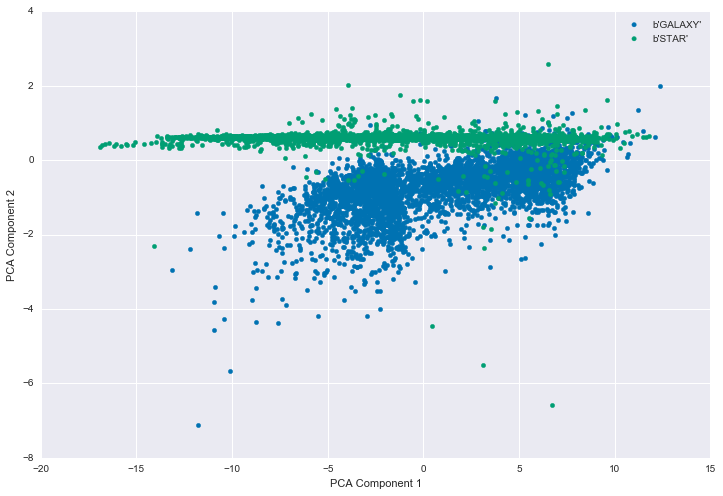

In [16]:
from sklearn.decomposition import PCA

# instantiate the PCA object
pca = PCA(n_components=2)

# fit and transform the samples:
X_pca = pca.fit_transform(X)

# make a plot object
fig, ax = plt.subplots(1, 1, figsize=(12,8))

# loop over number of classes:
for i,l in enumerate(np.unique(y)):
    members = y == l
    plt.scatter(X_pca[members, 0], X_pca[members, 1], 
                color=sns.color_palette("colorblind",8)[i],
                label=l)
    
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
    
plt.legend()



**Exercise 5**: Re-do the classification on the PCA components instead of the original features.

In [235]:
# Train PCA on training data set
X_pca_train = pca.fit_transform(X_train)

# apply to test set
X_pca_test = pca.transform(X_test)

# we'll leave the test set for later.

# instantiate the random forest classifier:
RFmod = RandomForestClassifier()

# do a grid search over the free random forest parameters:
pars = {"n_estimators": [10, 100, 300],
        "max_features": [1, 2], 
        "min_samples_leaf": [1,10]}

grid_results = GridSearchCV(RandomForestClassifier(), 
                            pars,
                            cv = 5)

grid_results.fit(X_pca_train, y_train)



GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 300], 'max_features': [1, 2], 'min_samples_leaf': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [236]:
grid_results.best_score_

0.96828571428571431

**Note**: In general, you should (cross-)validate both your data transformations and your classifiers!

But how do we know whether two components was really the right number to choose? perhaps it should have been three? Or four? Ideally, we would like to include the feature engineering in our cross validation procedure. In principle, you can do this by running a complicated for-loop. In practice, this is what `scikit-learn`s [Pipeline](http://scikit-learn.org/stable/modules/pipeline.html) is for! A `Pipeline` object takes a list of tuples of `("string", ScikitLearnObject)` pairs as input and strings them together (your feature vector `X` will be put first through the first object, then the second object and so on sequentially).

**Note**: `scikit-learn` distinguishes between *transformers* (i.e. classes that transform the features into something else, like PCA, t-SNE, StandardScaler, ...) and *predictors* (i.e. classes that produce predictions, such as random forests, logistic regression, ...). In a pipeline, all but the last objects must be transformers; the last object can be either.

**Exercise 6**: Make a pipeline including (1) a PCA object and (2) a random forest classifier. Cross-validate both the PCA components and the parameters of the random forest classifier. What is the best number of PCA components to use?

*Hint*: You can also use the convenience function [`make_pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) to creatue your pipeline. 

*Hint*: Check the documentation for the precise notation to use for cross-validating parameters.

In [28]:
from sklearn.pipeline import Pipeline

# make a list of name-estimator tuples
estimators = [('pca', PCA()), ('clf', RandomForestClassifier())]

# instantiate the pipeline
pipe = Pipeline(estimators)

# make a dictionary of parameters
params = dict(pca__n_components=[2, 4, 6, 8],
              clf__n_estimators=[10, 100, 300],
              clf__min_samples_leaf=[1,10])

# perform the grid search
grid_search = GridSearchCV(pipe, param_grid=params)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [2, 4, 6, 8], 'clf__min_samples_leaf': [1, 10], 'clf__n_estimators': [10, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.970571428571
{'pca__n_components': 6, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}


It looks like `n_components=6` works best.

## Comparing Algorithms

So far, we've just picked PCA because it's common. But what if there's a better algorithm for dimensionality reduction out there for our problem? Or what if you'd want to compare random forests to other classifiers? 

In this case, your best option is to split off a separate validation set, perform cross-validation for each algorithm separately, and then compare the results using hold-out cross validation and your validation set (**Note**: Do *not* use your test set for this! Your test set is *only* used for your final error estimate!)

Doing CV across algorithms is difficult, since the `KFoldCV` object needs to know which parameters belong to which algorithms, which is difficult to do. 

**Exercise 7**: Pick an algorithm from the [manifold learning](http://scikit-learn.org/stable/modules/manifold.html#manifold) library in `scikit-learn`, cross-validate a random forest for both, and compare the performance of both.

**Important**: Do *not* choose t-SNE. The reason is that t-SNE does not generalize to new samples! This means while it's useful for data visualization, you cannot train a t-SNE transformation (in the `scikit-learn` implementation) on one part of your data and apply it to another!

In [36]:
# First, let's redo the train-test split to split the training data 
# into training and hold-out validation set
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, 
                                                          test_size = 0.2, 
                                                          random_state = rs)


# Now we have to re-do the PCA pipeline:
from sklearn.pipeline import Pipeline

# make a list of name-estimator tuples
estimators = [('pca', PCA()), ('clf', RandomForestClassifier())]

# instantiate the pipeline
pipe = Pipeline(estimators)

# make a dictionary of parameters
params = dict(pca__n_components=[2, 4, 6, 8],
              clf__n_estimators=[10, 100, 300],
              clf__min_samples_leaf=[1,10])

# perform the grid search
grid_search = GridSearchCV(pipe, param_grid=params)
grid_search.fit(X_train_new, y_train_new)

print("Best score: " + str(grid_search.best_score_))
print("Best parameter set: " + str(grid_search.best_params_))
print("Validation score for model with PCA: " + str(grid_search.score(X_val, y_val)))

# I'm going to pick locally linear embedding here:
# LLE has two free parameters: 
# - the number of parameters to use `n_neighbors`
# - the number of components in the output
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline

# make a list of name-estimator tuples
estimators = [('lle', LocallyLinearEmbedding()), ('clf', RandomForestClassifier())]

# instantiate the pipeline
pipe2 = Pipeline(estimators)

# make a dictionary of parameters
params = dict(lle__n_components=[2, 4, 6, 8],
              lle__n_neighbors=[5, 10, 100],
              clf__n_estimators=[10, 100, 300],
              clf__min_samples_leaf=[1,10])

# perform the grid search
grid_search2 = GridSearchCV(pipe2, param_grid=params)
grid_search2.fit(X_train_new, y_train_new)

print("Best score: " + str(grid_search2.best_score_))
print("Best parameter set: " + str(grid_search2.best_params_))
print("Validation score for model with LLE: " + str(grid_search2.score(X_val, y_val)))


Best score: 0.971607142857
Best parameter set: {'pca__n_components': 4, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
Validation score for model with PCA: 0.961428571429
Best score: 0.971428571429
Best parameter set: {'lle__n_components': 4, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10, 'lle__n_neighbors': 100}
Validation score for model with PCA: 0.957142857143


Looks like PCA does slightly better as a dimensionality reduction method.

## Challenge Problem: Interpreting Results

Earlier today, we talked about interpreting machine learning models. Let's see how you would go about this in practice.

* Repeat your classification with a logistic regression model.
* Is the logistic regression model easier or harder to interpret? Why?
* Assume you're interested in which features are the most relevant to your classification (because they might have some bearing on the underlying physics). Would you do your classification on the original features or the PCA transformation? Why?
* Change the subset of parameters used in the logistic regression models. Look at the weights. Do they change? How? Does that affect your interpretability?

In [239]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(penalty="l2", Cs=10, cv=10)
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [240]:
lr.coef_

array([[-6.88906087,  1.95530763, -2.43079597,  0.57283392,  2.30630584,
        -2.34414147,  1.95936236,  4.29013675]])

**Answer 1**: Whether the model is easier or harder to interpret depends on what type of interpretability is desired. If you are interested in how the **features** influence the classification, the logistic regression model is easier to interpret: because random forests is an ensemble method, it's very hard to understand in detail how a prediction comes about (since the individual decision trees may have very different structures). However, for very large feature spaces with complicated, engineered features, your linear model (the logistic regression model) loses interpretability in how the parameters affect the outcomes just as much.

**Answer 2**: The more feature engineering you do, the harder it will be to interpret the results. The PCA features are a linear transformation of your original eight features. But what do they mean in physical terms? Who knows?


In [242]:
# let's leave out the first parameter and see whether the coefficients change:
lr.fit(X_train[:,1:], y_train)
lr.coef_

array([[ 13.85785953, -18.54078442,   0.43157384,   5.81193484,
         -8.7399514 ,  -3.4353291 ,  10.01516215]])

**Answer 3**: Some of the coefficients just changed sign! This is one of the problems with directly interpreting linear models: they are quite sensitive to the structure of the feature space. If you took these parameters and interpreted them in a causal sense, you might get completely different causal inferences depending on which parameters you use so be careful to check how robust your model is to changes in the feature space!

## Even More Challenging Challenge Problem: Implementing Your Own Estimator

Sometimes, you might want to use algorithms, for example for feature engineering, that are not implemented in scikit-learn. But perhaps these transformations still have free parameters to estimate. What to do? 

`scikit-learn` classes inherit from certain base classes that make it easy to implement your own objects. Below is an example I wrote for a machine learning model on time series, where I wanted to re-bin the time series in different ways and and optimize the rebinning factor with respect to the classification afterwards.

In [233]:
from sklearn.base import BaseEstimator, TransformerMixin

class RebinTimeseries(BaseEstimator, TransformerMixin):

    def __init__(self, n=4, method="average"):

        """
        Initialize hyperparameters

        :param n: number of samples to bin
        :param method: "average" or "sum" the samples within a bin?
        :return:
        """

        self.n = n ## save number of bins to average together
        self.method = method

        return


    def fit(self,X):
        """
        I don't really need a fit method!
        """
        
        ## set number of light curves (L) and 
        ## number of samples per light curve (k)
        return self
        
        
    def transform(self, X):
        self.L, self.K = X.shape

    
        ## set the number of binned samples per light curve
        K_binned = int(self.K/self.n)
        
        ## if the number of samples in the original light curve
        ## is not divisible by n, then chop off the last few samples of 
        ## the light curve to make it divisible
        #print("X shape: " + str(X.shape))

        if K_binned*self.n < self.K:
            X = X[:,:self.n*K_binned]
        
        ## the array for the new, binned light curves
        X_binned = np.zeros((self.L, K_binned))
        
        if self.method in ["average", "mean"]:
            method = np.mean
        elif self.method == "sum":
            method = np.sum
        else:
            raise Exception("Method not recognized!")
        
        #print("X shape: " + str(X.shape))
        #print("L: " + str(self.L))
        for i in xrange(self.L):
            t_reshape = X[i,:].reshape((K_binned, self.n))
            X_binned[i,:] = method(t_reshape, axis=1)
        
        return X_binned


    def predict(self, X):
        pass
    
    def score(self, X):
        pass

    def fit_transform(self, X, y=None):

        self.fit(X)
        X_binned = self.transform(X)

        return X_binned


Here are the important things about writing transformer objects for use in scikit-learn:
* The class must have the following methods:
    - `fit`: fit your training data
    - `transform`: transform your training data into the new representation
    - `predict`: predict new examples
    - `score`: score predictions
    - `fit_transform` is optional (I think)
* The `__init__` method *only* sets up parameters. Don't put any relevant code in there (this is convention more than anything else, but it's a good one to follow!)
* The `fit` method is always called in a `Pipeline` object (either on its own or as part of `fit_transform`). It usually modifies the internal state of the object, so returning `self` (i.e. the object itself) is usually fine.
* For transformer objects, which don't need scoring and prediction methods, you can just return `pass` as above.

**Exercise 8**: Last time, you learned that the SDSS photometric classifier uses a single hard cut to separate stars and galaxies in imaging data:
$$\mathtt{psfMag} - \mathtt{cmodelMag} \gt 0.145,$$
sources that satisfy this criteria are considered galaxies.

* Implement an object that takes $\mathtt{psfMag}$ and $\mathtt{cmodelMag}$ as inputs and has a free parameter `s` that sets the value above which a source is considered a galaxy. 
* Implement a `transform` methods that returns a single binary feature that is one if $$\mathtt{psfMag} - \mathtt{cmodelMag} \gt p$$ and zero otherwise. 
* Add this feature to your optimized set of features consisting of either the PCA or your alternative representation, and run a random forest classifier on both. Run a CV on all components involved.

*Hint*: $\mathtt{psfMag}$ and $\mathtt{cmodelMag}$ are the first and the last column in your feature vector, respectively.

*Hint*: You can use [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion) to combine the outputs of two transformers in a single data set. (Note that using pipeline with all three will *chain* them, rather than compute the feature union, followed by a classifier). You can input your `FeatureUnion` object into `Pipeline`.


In [259]:
class PSFMagThreshold(BaseEstimator, TransformerMixin):

    def __init__(self, p=1.45,):

        """
        Initialize hyperparameters

        Parameters
        ----------
        p : float
            The threshold for the magnitude - model magnitude
        """

        self.p = p # store parameter in object
        
        return


    def fit(self,X):
        """
        I don't really need a fit method!
        """
        return self
        
        
    def transform(self, X):

        # extract relevant columns
        psfmag = X[:,0]
        c_psfmag = X[:,-1]
        
        # compute difference
        d_psfmag = psfmag - c_psfmag
        
        # make a 1D array of length N
        X_new = np.zeros(X.shape[0])
        
        X_new[d_psfmag > self.p] = 1.0
        
        # IMPORTANT: Your output vector must be a COLUMN vector
        # You can achieve this with the numpy function atleast_2D()
        # and the numpy function transpose()
        return np.atleast_2d(X_new).T


    def predict(self, X):
        pass
    
    def score(self, X):
        pass

    def fit_transform(self, X, y=None):

        self.fit(X)
        X_new = self.transform(X)

        return X_new



In [260]:
pt = PSFMagThreshold(p=1.45)
X_pt = pt.fit_transform(X)

Now let's make a feature set that combines this feature with the PCA features:

In [268]:
from sklearn.pipeline import FeatureUnion

transformers = [("pca", PCA(n_components=2)),
                ("pt", PSFMagThreshold(p=1.45))]

feat_union = FeatureUnion(transformers)

X_transformed = feat_union.fit_transform(X_train)

Now we can build the pipeline:

In [276]:
# combine the 
transformers = [("pca", PCA()),
                ("pt", PSFMagThreshold(p=1.45))]

feat_union = FeatureUnion(transformers)

estimators = [("feats", feat_union),
        ("clf", RandomForestClassifier())]

pipe_c = Pipeline(estimators)

# make the parameter set
params = dict(feats__pca__n_components=[2, 4, 6, 8],
              feats__pt__p=[0.5, 0.9, 1.45, 2.0],
              clf__n_estimators=[10, 100, 300],
              clf__min_samples_leaf=[1,10])

# perform the grid search
grid_search_c = GridSearchCV(pipe_c, param_grid=params)
grid_search_c.fit(X_train_new, y_train_new)

# print validation score
print("Best score: " + str(grid_search_c.best_score_))
print("Best parameter set: " + str(grid_search_c.best_params_))
print("Validation score: " + str(grid_search_c.score(X_val, y_val)))


Best score: 0.9725
Best parameter set: {'feats__pca__n_components': 4, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100, 'feats__pt__p': 0.5}
Validation score: 0.961428571429


## Choosing The Right Scoring Function

As a standard, the algorithms in `scikit-learn` use `accuracy` to score results. The accuracy is basically the raw fraction of correctly classified samples in your validation or test set. 

**Question**: Is this scoring function always the best method to use? Why (not)? Can you think of alternatives to use?

Let's make a heavily biased data set:

In [456]:
# all stars
star_ind = np.argwhere(y == b"STAR").T[0]
# all galaxies
galaxy_ind = np.argwhere(y == b"GALAXY").T[0]

np.random.seed(100)
# new array with much fewer stars
star_ind_new = np.random.choice(star_ind, replace=False, size=int(len(star_ind)/80.0))

X_new = np.vstack((X[galaxy_ind], X[star_ind_new]))
y_new = np.hstack((y[galaxy_ind], y[star_ind_new]))

We have now made a really imbalanced data set with many galaxies and only a few stars:

In [457]:
print(len(y_new[y_new == b"GALAXY"]))
print(len(y_new[y_new == b"STAR"]))

4652
66


**Exercise 10**: Run a logistic regression classifier on this data, for a very low regularization (0.0001) and a very large regularization (10000) parameter. Print the accuracy and a confusion matrix of the results for each run. How many mis-classified samples are in each? Where do the mis-classifications end up? If you were to run a cross validation on this, could you be sure to get a good model? Why (not)?

*Hint*: Our imbalanced class, the one we're interested in, is the  

In [458]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y_new, 
                                                        test_size = 0.3, 
                                                        random_state = 20)

C_all = [0.0001, 10000]

for C in C_all:
    
    lr = LogisticRegression(penalty='l2', C=C)

    lr.fit(X_train2, y_train2)
    y_pred = lr.predict(X_test2)

    print("The accuracy score for C = %i is %.4f"%(C, accuracy_score(y_test2, y_pred)))

    cm = confusion_matrix(y_test2, y_pred, labels=np.unique(y))
    print(cm)



The accuracy score for C = 0 is 0.9866
[[1397    0]
 [  19    0]]
The accuracy score for C = 10000 is 0.9859
[[1392    5]
 [  15    4]]


**Exercise 11**: Take a look at the [metrics](http://scikit-learn.org/stable/modules/model_evaluation.html) implemented for model evaluation in `scikit-learn`, in particular the different versions of the [F1 score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score). Is there a metric that may be more suited to the task above? Which one? 

In [459]:
for C in C_all:
    
    lr = LogisticRegression(penalty='l2', C=C)

    lr.fit(X_train2, y_train2)
    y_pred = lr.predict(X_test2)

    print("The accuracy score for C = %i is %.4f"%(C, accuracy_score(y_test2, y_pred)))
    print("The F1 score for C = %.5f is %.4f"%(C, f1_score(y_test2, y_pred, 
                                                         pos_label=b"STAR", 
                                                         average="binary")))


    cm = confusion_matrix(y_test2, y_pred, labels=np.unique(y))
    print(cm)




The accuracy score for C = 0 is 0.9866
The F1 score for C = 0.00010 is 0.0000
[[1397    0]
 [  19    0]]
The accuracy score for C = 10000 is 0.9859
The F1 score for C = 10000.00000 is 0.2857
[[1392    5]
 [  15    4]]


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


As you can see, the accuracy for the model that mis-classifies all stars ends up being higher than the accuracy for the model that only mis-classifies some of them (admittedly, still more than you'd want). So when doing cross-validation, you're quite likely to end up with a model that mis-classifies all your samples from the rare class into the more common class.  
If the rare class is actually one that you care about (say, gravitational wave triggers), then this is *very* bad behaviour.

The F-score, conversely, is zero for stars with the small regularization parameter (since there are no stars in this group), and not very high, but higher for the large regularization parameter. This is more what we'd like to see if we're interested in the rare class.